## Histopathology Stain Transfer with Pix2Pix 

**Keywords: GANs, Pix2Pix, Histopathology, PyTorch Lightning**

Color variation in digital histopathology images arise due to differences in processes and lab conditions during acquisition and digitization. Stain normalization --in preparation for downstream automated image analysis tasks-- is an important preprocessing task that normalizes or reduces these color and intensity variations. While there are many stain normalization methods that use conventional image processing, style transfer techniques using generative adversarial networks (cGANs <a href="#ref1">[1]</a>, CycleGANs <a href="#ref1">[2]</a>, Pix2Pix <a href="#ref1">[3]</a>) have only recently been applied to this problem.   
In this exercise, we'll use Pix2Pix for stain transfer (i.e. we will generate histopathological patterns within a certain color distribution).

**Pix2Pix**   
Pix2Pix <a href="#ref1">[4]</a> is a conditional GAN (cGAN) set up as a  pairwise image translation algorithm. The pair consists of a target image and an input condition/label image which is passed to the generator. It should be noted that unlike the cGAN the input is an image, not a noise+label vector. The components of Pix2Pix architecture are a follows: 

*Generator:* A U-Net, which has skip connections, is used so that low level information can be passed from input image to output image. Noise in the form of dropout is applied to several layers of the generator  instead of an input noise used in cGAN models.

*Discriminator:* The discriminator is a PatchGAN network. It classifies smaller patches of the input image (either real or fake) instead of discriminating the entire image at once. See the [PatchGAN section](#PatchGAN) below.
 
*Loss:* In addition to the task of fooling the discriminator, the genrator has to generate images close to the ground truth. For this an L1 loss is applied to the generator. This L1 loss however, is only able to preserve low-frequency details in an image and produces blurry images. 
The PatchGAN discriminator can learn high-frequency features. By fusing the two types of losses, both high  and low-frequency details can be learned and generated.

**Pix2Pix stain transfer**   
Here the RGB color and corresponding grayscale transform of an image tile serve as target/condition image pairs. Grayscale images are normalized across channels and serve as a neutral template for stain-style transfer. As training progresses, the stain style generalizes capturing the statistics over the entire training set which had been acquired from different labs. It should be noted that while the Pix2Pix algorithm requires paired data for training, it is easy to satisfy this by applying grayscale transforms.


**Implementation**  
*Training:* Color/grayscale image pairs are derived from the H&E stained PCam dataset.
The grayscale images serve as input to the generator. The generator outputs stained color images.
The discriminator has two input pairs: the generated image/grayscale image pair serves as the fake input, the color/grayscale image pair is the real input. See the figure below.   
The network is trained using the most of the same parameters as the original Pix2Pix paper (see the [Config section](#config)).    
*Evaluation:* We plot the target image and generated image during the training cycle. In real world implementations, the target image and generated image are compared using metrics such as PSNR, SSIM as well as human visual perception. The generated image can also be validated on a clinical use-case such as classification.  
*Code:* We use PyTorch Lightning. Sections of code in the notebook below that were taken from the public domain have been acknowledged.

<br>  
<br>

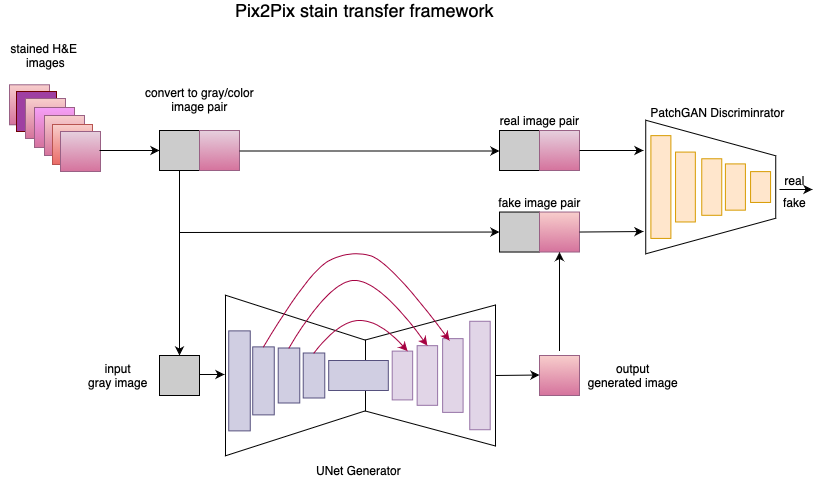

## I. Imports/Globals

In [ ]:
import os
from glob import glob
import numpy as np
import copy
import random
import time

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
#from torchmetrics.functional import (psnr, ssim, accuracy)
 
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

print(f'PyTorch version: {torch.__version__}')
print(f'Pytorch Lightning: {pl.__version__}')

#### Config <a id='config'></a>
We use most of the same hyperparameters as the original Pix2Pix paper <a href="#ref1">[4]</a>, 
namely: `image_size` = 256, `learning_rate` = 0.0002, the Adam solver, adversarial loss functions.  

We experimented with two parameters: the generator's *L1* loss weighting function `lambda` (= 100 and 200) and
the `batch_size` (= 1 and 4). In the limited number of experiments we observed, `lambda`=100 and `batch_size`=4 gave best results.

In [ ]:
cfg = dict(
    seed = 2022,
    train_dir = "../input/histopathologic-cancer-detection/train/",
    # val_dir = "../input/histopathologic-cancer-detection/test/",
    num_images = 20000,
    image_size = 256,
    
    num_epochs = 31,
    batch_size = 4,       # the original paper used instance normalization i.e. bs = 1
    lr = 2e-4,
    display_step = 5,
    adversarial_criterion = nn.BCEWithLogitsLoss(),  
    recon_criterion = nn.L1Loss(), 
    lambda_recon = 100,   # the original paper lambda = 100
)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(cfg['seed'])

## II. Data

The Pix2Pix GAN is robust and generalizes well when trained. The Pix2Pix authors showed good results could be obtained with small datasets of 91, 400 or 1096 images trained over 200 epochs or large datasets (1.2 million images -- ImageNet) trained in as little as 6 epochs. 

> Facades: 400 training images trained for 200 epochs, batch size 1   
> Maps↔aerial photograph: 1096 training images scraped from Google Maps, trained for 200 epochs, batch size 1   
> BW↔color photograph: 1.2 million training images, trained for 6 epochs, batch size 4  

With histopathology and radiology data, authors have typically used 3000-10,000 image tiles to train the GAN network.

**PCam data**
We use PCam images from the [CAMELYON16](https://camelyon16.grand-challenge.org/Data/) database. This consists of H&E stained lymph node sections of breast tissue sourced from two different centers. The images are 96x96 tiles of whole slide images. For this run we use 20,000 training images; this can be increased or decreased based on time/compute/fidelity tradeoffs.

**Preprocessing**
1. the image tiles are resized to 256x256 as per the Pix2Pix algorithm  
2. grayscale/color image pairs are generated from the H&E stained images   

In [ ]:
"""
This transform pipeline is applied to the grayscale and color image pair. It will:
 - resize both images from 96 to 256
 - augment/flip the images with p = 0.5
 - scale the pixel values to [-1,1]
 - convert the images to tensors     
"""

both_transform = A.Compose(
    [
        A.Resize(width=cfg['image_size'], height=cfg['image_size']),   # default INTER_LINEAR interpolation
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ], additional_targets={"image0": "image"},
)

In [ ]:
class CancerDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        #self.list_files = os.listdir(self.base_dir)
        self.list_files = glob(os.path.join(self.base_dir, "*.tif"))[:cfg['num_images']]
        self.transform = transform

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_path = self.list_files[index]
        img = cv2.imread(img_path)
        color_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # convert to 3-channel grayscale
        gray_image = cv2.cvtColor(cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY), 
                                  cv2.COLOR_GRAY2RGB)
       
        if self.transform is not None:
            transformed = self.transform(image=color_image, image0=gray_image)
            color_image = transformed["image"]  # real image/target
            gray_image = transformed["image0"]  # conditioned image/input
      
        return color_image, gray_image

#### Visualizations

##### Original images

In [ ]:
def visualize_original_images(dir, sample=10):
    # display 10 images
    fig = plt.figure(figsize=(15, 5))
    train_imgs = os.listdir(dir)[:cfg['num_images']]
    train_imgs = glob(os.path.join(dir, "*.tif"))
    for idx, img in enumerate(np.random.choice(train_imgs, sample)):
        ax = fig.add_subplot(2, sample//2, idx+1, xticks=[], yticks=[])
        im = Image.open(img)
        plt.imshow(im)

In [ ]:
visualize_original_images(cfg['train_dir'], 10)

Note the intensity and color variations in the images (the [PCam dataset](https://github.com/basveeling/pcam) is acquired and digitized from two different laboratories).

##### Augmented Color/Gray Image Pairs

In [ ]:
# from https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform 
                                   if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 20))
    for i in range(samples):
        color_image, gray_image = dataset[idx]
        ax[i, 0].imshow(color_image)
        ax[i, 1].imshow(gray_image)
        ax[i, 0].set_title("color")
        ax[i, 1].set_title("gray")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.suptitle('Augmented images', y=1.0, fontsize=18)
    plt.tight_layout()
    plt.show()

In [ ]:
train_dataset = CancerDataset(base_dir=cfg['train_dir'], transform=both_transform)
visualize_augmentations(train_dataset, idx=55)

## III. Model

Portions of the Pix2Pix [Pytorch Lightning implementation](https://colab.research.google.com/github/LibreCV/blog/blob/master/_notebooks/2021-02-13-Pix2Pix%20explained%20with%20code.ipynb) below is from Aniket Maurya.

In [ ]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [ ]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

#### UNet Generator

In [ ]:
class UNetGenerator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

#### PatchGAN discriminator <a id='PatchGAN'></a>
The basic idea of the PatchGAN discriminator model is to classify an 𝑁×𝑁 region in the 𝑀×𝑀 input image (𝑁<𝑀) as ’real’ or ’fake’,  In our case, 𝑀=256 and 𝑁=70. The output of the discriminator model is a map with 16×16 values scaled using a sigmoid activation function. These 16 values are combined to give the probability of the entire input image being ’real’ or ’fake’.  

In [ ]:
class PatchGANDiscriminator(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

#### Utils

In [ ]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
def display_progress(cond, real, fake, current_epoch, path, figsize=(10,5)):
    """
    Save cond, real (original) and generated (fake)
    images in one panel 
    """
    cond = cond.detach().cpu().permute(1, 2, 0)   
    real = real.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    
    images = [cond, real, fake]
    titles = ['input','real','generated']
    print(f'Epoch: {current_epoch}')
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for idx,img in enumerate(images):
        ax[idx].imshow(img)
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
    plt.savefig(path)
    plt.show()

In [ ]:
class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=100, display_step=10):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        self.gen = UNetGenerator(in_channels, out_channels)
        self.disc = PatchGANDiscriminator(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.disc = self.disc.apply(_weights_init)

        self.adversarial_criterion = cfg['adversarial_criterion']   #nn.BCEWithLogitsLoss()
        self.recon_criterion = cfg['recon_criterion']               #nn.L1Loss()
        
       
    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.disc(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.disc(fake_images, conditioned_images)

        real_logits = self.disc(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.disc.parameters(), lr=lr)
        return disc_opt, gen_opt

    # the optimizer index is used to index multiple (here two) optimizers
    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            display_progress(condition[0], real[0], fake[0], self.current_epoch, 
                             path="/kaggle/working/img_{}".format(self.current_epoch))
        return loss

## IV. Training

In [ ]:
train_dataset = CancerDataset(base_dir=cfg['train_dir'], transform=both_transform)
dataloader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)

pix2pix = Pix2Pix(3, 3, learning_rate=cfg['lr'], lambda_recon=cfg['lambda_recon'], 
                  display_step=cfg['display_step'])
trainer = pl.Trainer(max_epochs=cfg['num_epochs'], gpus=-1)
trainer.fit(pix2pix, dataloader)

In [ ]:
#  Start tensorboard
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

## V. References and further reading

<a name="ref1"></a>[1] [Hyungjoo Cho et al. 'Neural Stain-Style Transfer Learning using GAN for Histopathological Images.' ACML (2017)](https://arxiv.org/pdf/1710.08543.pdf)  
<a name="ref1"></a>[2] [M Tarek Shaban et al. 'StainGAN: Stain Style Transfer for Digital Histological Images'](https://arxiv.org/pdf/1804.01601.pdf)    
<a name="ref1"></a>[3] [Pegah Salehi et al. 'Pix2Pix-based Stain-to-Stain Translation: A Solution for Robust Stain Normalization in Histopathology Images Analysis'](https://arxiv.org/pdf/2002.00647.pdf)  
<a name="ref1"></a>[4] [Phillip Isola et al. 'Image-to-Image Translation with Conditional Adversarial Networks.'](https://arxiv.org/pdf/1611.07004v3)  
<a name="ref1"></a>[5] [BenTaieb, A., Hamarneh, G. 'Adversarial stain transfer for histopathology image analysis.' IEEE Transactions on Medical Imaging (2017)](http://www.sfu.ca/~abentaie/papers/TMI2017.pdf)  

**Author: Meena Mani**   
**Date: March 2022**